In [148]:
import os

import numpy as np
import torch
import cv2

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [149]:
# setup pytorch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # for multi-GPU systems, force single GPU
if torch.cuda.is_available():
    device_map = "cuda:0"  # force single, first GPU
    device = "cuda"
elif torch.backends.mps.is_available():
    device_map = "auto"
    device = "cpu"  # MPS does not support 64-bit floats in tensors
else:
    device_map = "auto"
    device = "cpu"

print(f"Using device: {device}")

Using device: cuda


In [150]:
def show_anns(masks, background=None, title="Original"):
    """
    Visualize a list of SAM-style masks.
    
    Parameters:
    - masks: list of dictionaries, each with at least a 'segmentation' key containing a boolean np.ndarray
    - background: optional (H, W, 3) image to show under the masks
    """
    if not masks:
        print("No masks to visualize.")
        return

    height, width = masks[0]['segmentation'].shape
    fig, ax = plt.subplots(figsize=(10, 6))

    if background is not None:
        ax.imshow(background)
    else:
        ax.imshow(np.ones((height, width, 3)))  # white background

    # Use distinct colors for each mask
    colors = list(mcolors.TABLEAU_COLORS.values())

    for i, mask_data in enumerate(masks):
        mask = mask_data['segmentation']
        color = colors[i % len(colors)]
        ax.imshow(np.ma.masked_where(~mask, mask), cmap=mcolors.ListedColormap([color]), alpha=0.5)

        # Optional: label mask index
        indices = np.argwhere(mask)
        if indices.size > 0:
            y, x = indices[0]
            ax.text(x, y, str(i + 1), color="white", bbox=dict(facecolor=color, edgecolor='black'),
                    fontsize=12, fontweight='bold')

    ax.axis('on')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )

Original image dimensions: 2528 x 2750
Number of channels: 3
Resized image dimensions: 1882 x 2047


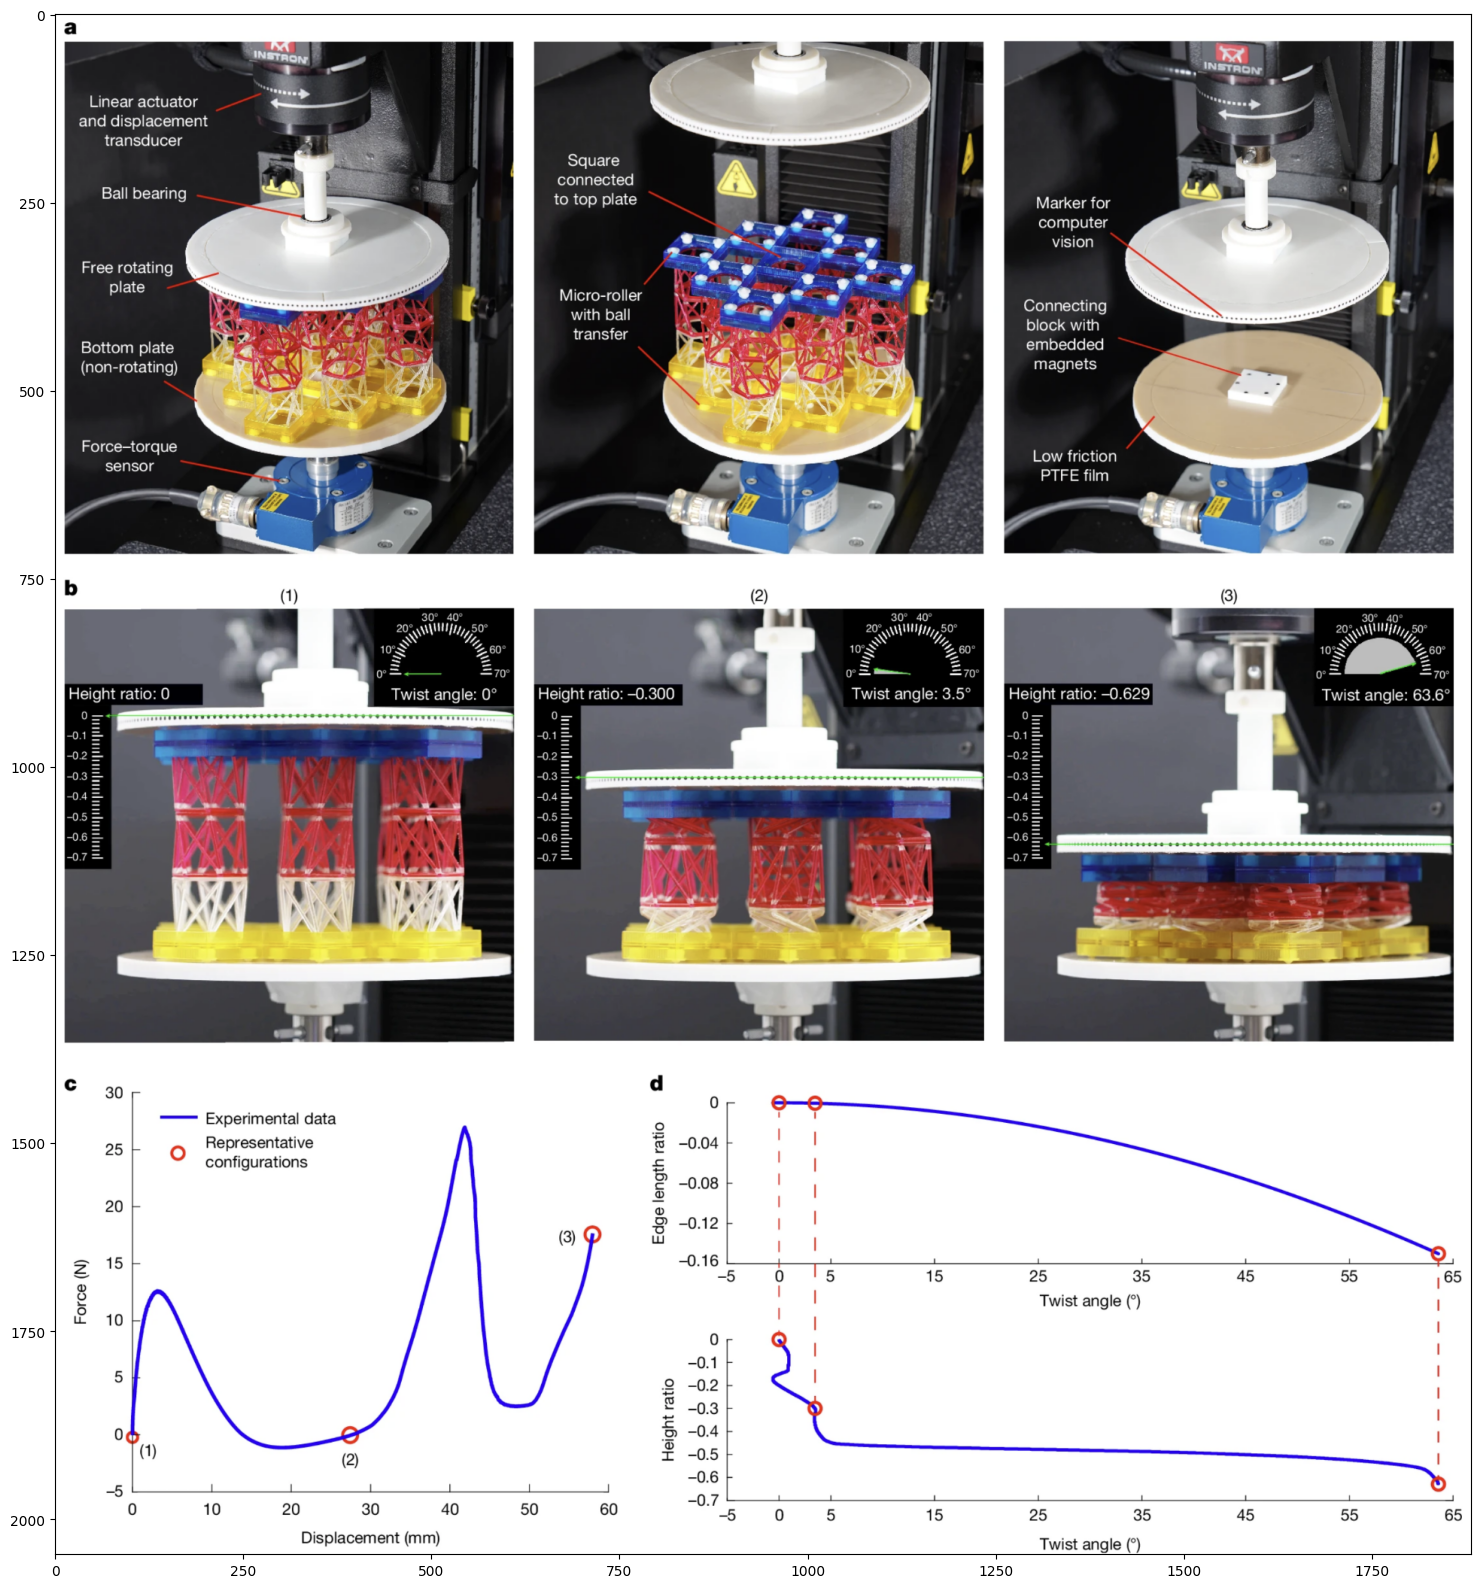

In [205]:
files = [
    # clear strucure, but lots of distractors in segmentation
    {
        "source": "nature-papers",
        "name": "figure-3",
        "file": "examples/nature-papers/figure-3.png"
    },
    {
        "source": "eriks-paper",
        "name": "figure-1-instrument",
        "file": "examples/eriks-papers/figure-1-instrument.png"
    },
    # open-ended
    {
        "source": "deliberate-practice",
        "name": "figure-3",
        "file": "examples/deliberate-practice/figure-3.png"
    },
    {
        "source": "simphony",
        "name": "figure-5",
        "file": "examples/simphony/figure-5.png"
    },
    # well segemented, process-like
    {
        "source": "epm",
        "name": "Y18-1010-figure1",
        "file": "examples/epm/Y18-1010-Figure1-1.png"
    },
    {
        "source": "orchestration-scripts",
        "name": "figure-2",
        "file": "examples/orchestration-scripts/figure-2.png"
    },
    {
        "source": "orchestration-scripts",
        "name": "figure-3",
        # "file": "examples/orchestration-scripts/figure-3.png"
        "file": "examples/orchestration-scripts/figure-3-new.png"
    },
    {
        "source": "co11ab",
        "name": "figure-1",
        "file": "examples/co11ab/figure-1.png"
    },
    {
        "source": "co11ab",
        "name": "figure-2",
        "file": "examples/co11ab/figure-2.png"
    },
]
index = 0
source = files[index]["source"]
name = files[index]["name"]
file = files[index]["file"]

image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

height, width, channels = image.shape
print(f"Original image dimensions: {width} x {height}")
print(f"Number of channels: {channels}")

# resize image
dim = 2048
r = np.min([dim / image.shape[1], dim / image.shape[0]])
image = cv2.resize(image, (int(image.shape[1] * r), int(image.shape[0] * r)))
height, width, channels = image.shape
print(f"Resized image dimensions: {width} x {height}")

plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis("on")
plt.show()

# Mask Segmentation

In [206]:
def xywh_to_xyxy(box):
    x, y, w, h = box
    return [x, y, x + w, y + h]

def bboxes_overlap(box1, box2):
    x1_min, y1_min, x1_max, y1_max = xywh_to_xyxy(box1)
    x2_min, y2_min, x2_max, y2_max = xywh_to_xyxy(box2)

    return not (x1_max < x2_min or x2_max < x1_min or
                y1_max < y2_min or y2_max < y1_min)

def group_overlapping_bboxes(masks):
    bboxes = [m['bbox'] for m in masks]
    n = len(bboxes)
    visited = [False] * n
    groups = []

    for i in range(n):
        if visited[i]:
            continue
        group = [i]
        visited[i] = True
        changed = True

        while changed:
            changed = False
            for j in range(n):
                if not visited[j] and any(bboxes_overlap(bboxes[k], bboxes[j]) for k in group):
                    group.append(j)
                    visited[j] = True
                    changed = True

        groups.append(group)
    return groups

def merge_masks(mask_group, height, width):
    combined = np.zeros((height, width), dtype=bool)
    for mask_dict in mask_group:
        combined |= mask_dict['segmentation']
    return combined

def group_and_merge_sam_masks(masks):
    if not masks:
        return []

    height, width = masks[0]['segmentation'].shape
    groups = group_overlapping_bboxes(masks)
    merged_results = []

    for group_indices in groups:
        group = [masks[i] for i in group_indices]
        merged_mask = merge_masks(group, height, width)
        merged_results.append({
            'merged_mask': merged_mask,
            'original_indices': group_indices,
        })

    return merged_results

In [207]:
def visualize_merged_masks(merged_results, background=None, title="Overlapping Masks Merged"):
    """
    - merged_results: list of {'merged_mask': np.ndarray, 'original_indices': [...]}
    - background: optional (H, W, 3) image to show under the masks
    """
    height, width = merged_results[0]['merged_mask'].shape
    fig, ax = plt.subplots(figsize=(10, 6))

    if background is not None:
        ax.imshow(background)
    else:
        ax.imshow(np.ones((height, width, 3)))  # white background

    # Use distinct colors for each merged group
    colors = list(mcolors.TABLEAU_COLORS.values())

    for i, result in enumerate(merged_results):
        mask = result['merged_mask']
        color = colors[i % len(colors)]
        ax.imshow(np.ma.masked_where(~mask, mask), cmap=mcolors.ListedColormap([color]), alpha=0.5)

        # Optional: label group index
        y, x = np.argwhere(mask)[0]
        ax.text(x, y, str(i + 1), color="white", bbox=dict(facecolor=color, edgecolor='black'),  fontsize=12, fontweight='bold')

    ax.axis('on')
    ax.set_title(title)
    plt.tight_layout()
    # plt.savefig(f"./results/{source}-{name}-seg-combined.png")
    plt.show()

## Automatic mask generation with regular SAM

In [208]:
# from sam2.build_sam import build_sam2
# from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
# model_cfg = "sam2.1_hiera_l.yaml"

# sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

# mask_generator = SAM2AutomaticMaskGenerator(
#     model=sam2,
#     points_per_side=16,
#     points_per_batch=128,
#     pred_iou_thresh=0.9,
#     stability_score_thresh=0.95,
#     stability_score_offset=1.0,
#     crop_n_layers=0,
#     box_nms_thresh=0.7,
#     crop_n_points_downscale_factor=1,
#     min_mask_region_area=100,
#     use_m2m=True,
# )

In [209]:
# masks = mask_generator.generate(image)
# print(len(masks))
# show_anns(masks, background=image, title=f"SAM 2 Original Mask -- {source} (figure: {name})\n\n")

In [210]:
# merged = group_and_merge_sam_masks(masks)
# print(len(merged))
# visualize_merged_masks(merged, background=image, title=f"SAM 2 Overlapping Masks Merged -- {source} (figure: {name})\n\n")

In [211]:
# torch.cuda.empty_cache()

## Automatic mask generation with fine-tuned model

In [212]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    # load_model="./finetuned-models/final/fine_tuned_sam2_32000_05-27-25.pt",
    load_model="./finetuned-models/final/fine_tuned_sam2_40000_05-28-25.pt",
    points_per_side=16,
    points_per_batch=128,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.95,
    stability_score_offset=1.0,
    crop_n_layers=0,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=100,
    use_m2m=True,
)

7


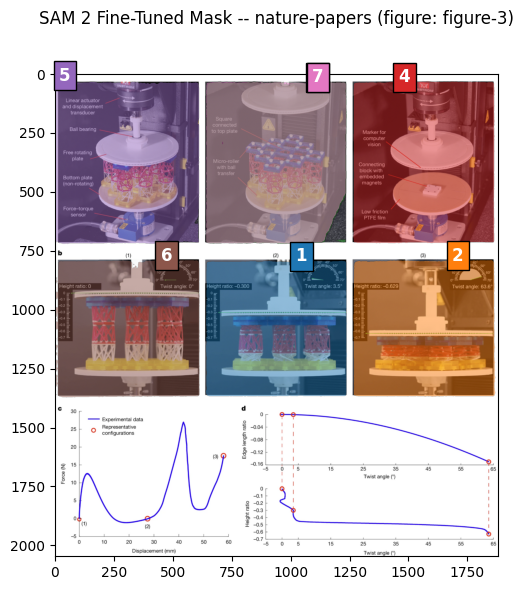

In [213]:
masks = mask_generator.generate(image)
print(len(masks))
show_anns(masks, background=image, title=f"SAM 2 Fine-Tuned Mask -- {source} (figure: {name})\n\n")

5


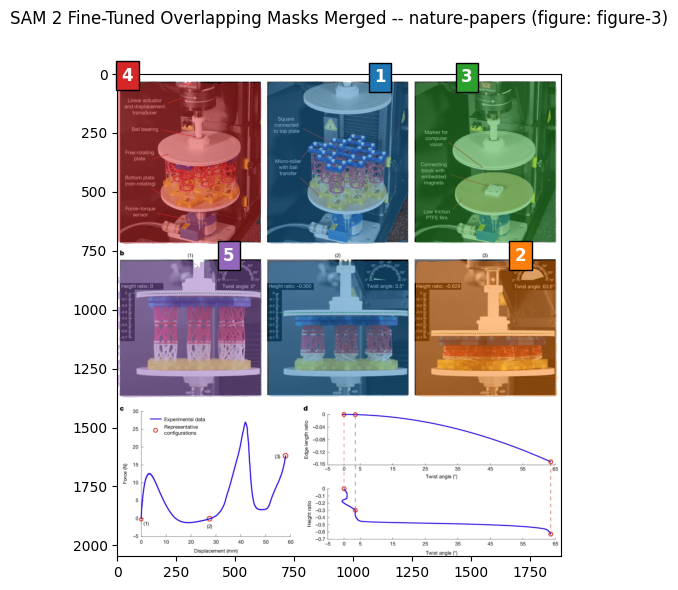

In [214]:
merged = group_and_merge_sam_masks(masks)
print(len(merged))
visualize_merged_masks(merged, background=image, title=f"SAM 2 Fine-Tuned Overlapping Masks Merged -- {source} (figure: {name})\n\n")

In [215]:
torch.cuda.empty_cache()